# 🔹 Sabriya Sowers' Titanic Survival Classification – Decision Tree, SVM, and Neural Network 🔹

**Author:** Sabriya Sowers  
**Date:** November 5, 2025

## Introduction
This notebook uses the Titanic dataset to train and evaluate three classification models (Decision Tree, SVM, and Neural Network) to predict passenger survival. We prepare the data, create features, split into training and test sets, and compare model performance across different input feature setups.

## Section 1. Import and Inspect the Data

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap

# Load dataset from seaborn
titanic = sns.load_dataset("titanic")

In [ ]:
# Displays basic dataset info
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [ ]:
# Display first 10 rows
print(titanic.head(10))


   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes

## Section 2. Data Exploration and Preparation

In [ ]:
# Check for missing values
titanic.isnull().sum()


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [ ]:
# Find the median age value and replace missing ages with that value
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

In [ ]:
# Fill in missing values for feature embark_town using the mode (most common value)
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

# Verify: should print 0
# print(int(titanic['embark_town'].isna().sum()))

2.2 Feature Engineering

In [ ]:
# Create new feature called "family size" using existing data 
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Map categories to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)

# Review new features
titanic[['sex', 'family_size', 'embarked', 'alone']].head(5)


,sex,family_size,embarked,alone
0,0,2,2.0,0
1,1,2,0.0,0
2,1,1,2.0,1
3,1,2,2.0,0
4,0,1,2.0,1


## Section 3. Feature Selection and Justification
3.1 Choose features and target

Case 1: 
input features: alone
target: survived

Case 2:
input features - age
target: survived

Case 3:
input features -  age and family_size 
target: survived

## 3.2 Define X (features) and y (target)

In [ ]:
# Case 1: Feature = alone
# Select the feature 'alone' as input
X1 = titanic[['alone']]

# Select 'survived' as the target for the same rows
y1 = titanic['survived']

In [ ]:
# Case 2: Feature = age (drop if na or not available)
# Select the feature 'age', but drop rows where age is missing
X2 = titanic[['age']].dropna()

# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

In [ ]:
# Case 3: Features = Age + Family Size (drop if na or not available)

# Select both 'age' and 'family_size', and drop rows where missing (na)
X3 = titanic[['age', 'family_size']].dropna()

# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']


Reflection:

1. Why are these features selected?
These features were chosen because they are easy to interpret and relate to behavior and circumstances on the ship. Feature “alone” and “family_size” show social context, while “age” provides demographic info.

1. Are there features that are likely to be highly predictive of survival?
Family size and age are likely to be more predictive of survival, since evacuation decisions are influenced by assisting families and children.

## Section 4. Train a Classification Model (Decision Tree)
4.1 Split the Data

In [ ]:
# Case 1: Feature = alone
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):

    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

print('Case 1 - Alone:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))

Case 1 - Alone:
Train size: 712 | Test size: 179


In [ ]:
# Case 2: Feature = age
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

print('Case 2 - Age:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))

Case 2 - Age:
Train size: 712 | Test size: 179


In [ ]:
# Case 3: Features = age + family_size
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print('Case 3 - Age + Family Size:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))


Case 3 - Age + Family Size:
Train size: 712 | Test size: 179


4.2 Create and Train Model (Decision Tree)

In [ ]:
# CASE 1: Decision Tree using alone
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# CASE 2: Decision Tree using age
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# CASE 3: Decision Tree using age and family_size
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


4.3 Predict and Evaluate Model Performance

In [ ]:
# Predict on training data
y1_pred = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - alone):")
print(classification_report(y1_train, y1_pred))

# Predict on test data
y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_test_pred))

Results for Decision Tree on training data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Results for Decision Tree on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



In [ ]:
# Predict on training data
y2_pred = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - age):")
print(classification_report(y2_train, y2_pred))

# Predict on test data
y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - age):")
print(classification_report(y2_test, y2_test_pred))

Results for Decision Tree on training data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41       273

    accuracy                           0.68       712
   macro avg       0.68      0.61      0.60       712
weighted avg       0.68      0.68      0.64       712

Results for Decision Tree on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       110
           1       0.50      0.17      0.26        69

    accuracy                           0.61       179
   macro avg       0.57      0.53      0.50       179
weighted avg       0.58      0.61      0.55       179



In [ ]:
# Predict on training data
y3_pred = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - age + family_size):")
print(classification_report(y3_train, y3_pred))

# Predict on test data
y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_test_pred))


Results for Decision Tree on training data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       439
           1       0.77      0.56      0.65       273

    accuracy                           0.77       712
   macro avg       0.77      0.73      0.74       712
weighted avg       0.77      0.77      0.76       712

Results for Decision Tree on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.65      0.75      0.69       110
           1       0.46      0.35      0.40        69

    accuracy                           0.59       179
   macro avg       0.55      0.55      0.54       179
weighted avg       0.57      0.59      0.58       179



4.4 Report Confusion Matrix (as a heatmap)

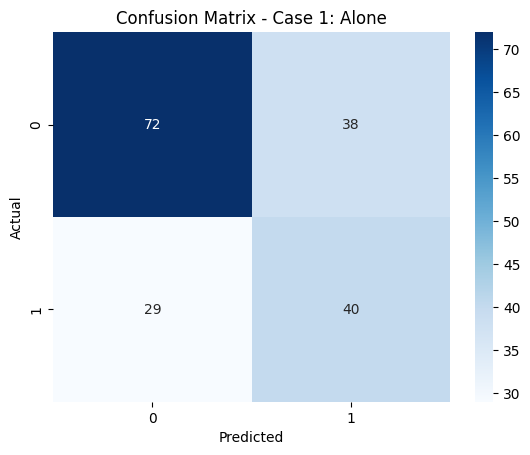

In [ ]:
# Create confusion matrix for test predictions (Case 1)
cm1 = confusion_matrix(y1_test, y1_test_pred)

# Plot heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 1: Alone')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

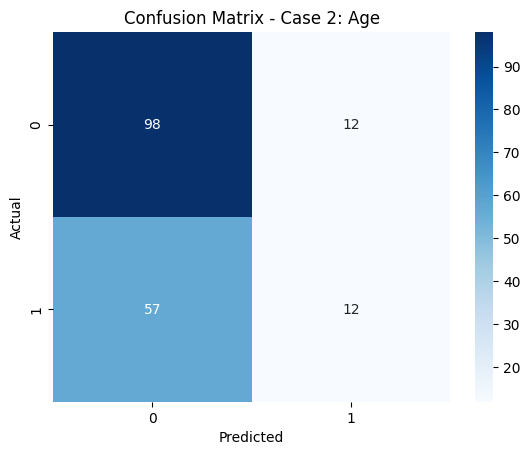

In [ ]:
# Create confusion matrix for test predictions (Case 2)
cm2 = confusion_matrix(y2_test, y2_test_pred)

# Plot heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 2: Age')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

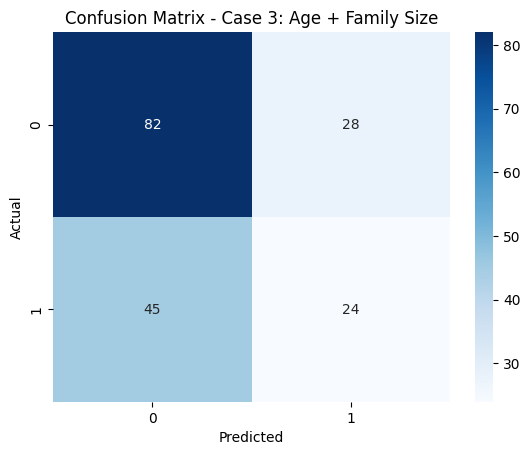

In [ ]:
# Create confusion matrix for test predictions (Case 3)
cm3 = confusion_matrix(y3_test, y3_test_pred)

# Plot heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 3: Age + Family Size')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

4.5 Report Decision Tree Plot

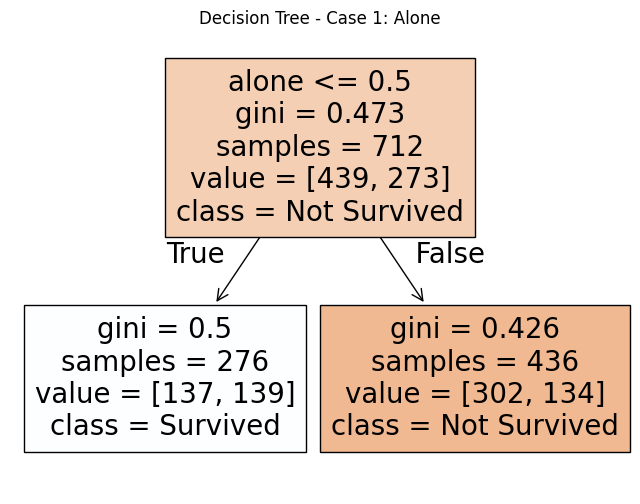

In [ ]:
# Plot Decision Tree for Case 1
fig = plt.figure(figsize=(8, 6))
plot_tree(tree_model1,
          feature_names=X1.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 1: Alone")
plt.show()

# Save image
fig.savefig("tree_case1_alone.png")

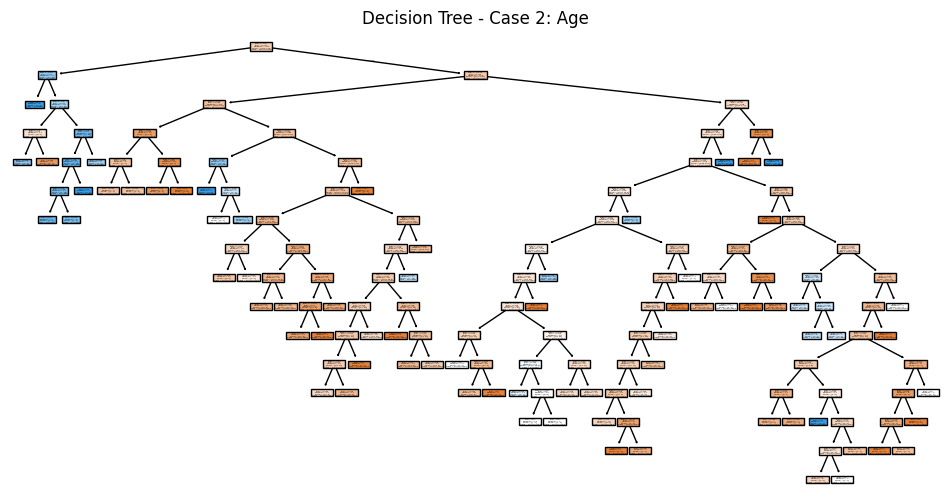

In [ ]:
# Plot Decision Tree for Case 2
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model2,
          feature_names=X2.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()

# Save image
fig.savefig("tree_case2_age.png")

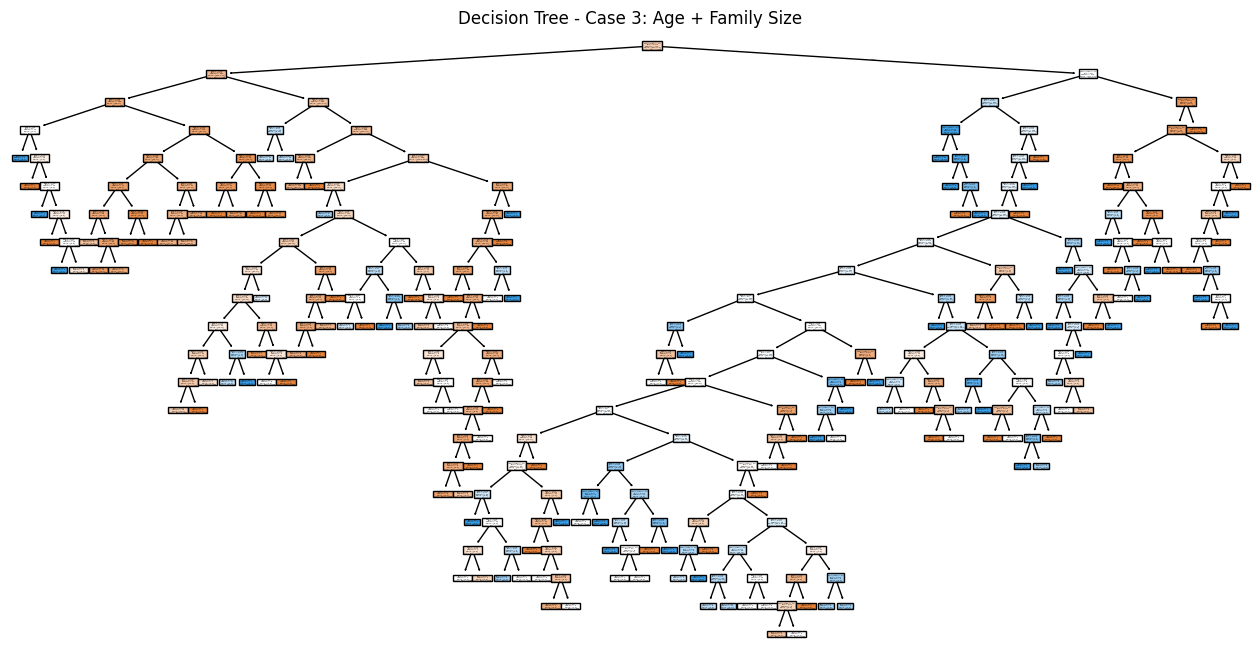

In [ ]:
# Plot Decision Tree for Case 3
fig = plt.figure(figsize=(16, 8))
plot_tree(tree_model3,
          feature_names=X3.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()

# Save image
fig.savefig("tree_case3_age_family.png")

Reflection 4:

1. How well did the different cases perform?
   - Case 1 (alone) had moderate performance with a test accuracy around 0.63. It was able to correctly identify some survivors, but the recall and F1 score for the survived group (class 1) were still fairly low. 
   - Case 2 (age) performed worse, especially for predicting the survived class, where recall dropped very low (around 0.17). 
   - Case 3 (age + family_size) performed much better on the training data, but the test accuracy dropped to 0.59, which shows that the model was overfitting.

2. Are there any surprising results?
Yes. I expected age to matter more, but the model using only age performed poorly, especially on survivors. I also expected adding family_size to improve performance, and while it did improve training results, it caused the model to overfit, meaning it did not generalize well to the test data.

1. Which inputs worked better?
Case 1 and Case 3 performed better than Case 2. Case 3 (age + family_size) looked strongest in training, but because of overfitting, it did not perform as well on the test data.

## Section 5. Compare Alternative Models (SVC, NN)

5.1 Train and Evaluate Model (SVC)

Case 1

In [ ]:
# CASE 1: SVC using 'alone'
svc_model1 = SVC()
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("Results for SVC on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_svc_pred))

Results for SVC on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



5.2 Visualize Support Vectors (1D Case 1 and 2D Case 3)

Case 2

In [ ]:
# CASE 2: SVC using 'age'
svc_model2 = SVC()  # default kernel = 'rbf'
svc_model2.fit(X2_train, y2_train)

y2_svc_pred = svc_model2.predict(X2_test)
print("Results for SVC on test data (Case 2 - age):")
print(classification_report(y2_test, y2_svc_pred))

Results for SVC on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179



In [ ]:
# CASE 3: SVC using 'age' + 'family_size'
svc_model3 = SVC()  # default kernel = 'rbf'
svc_model3.fit(X3_train, y3_train)

y3_svc_pred = svc_model3.predict(X3_test)
print("Results for SVC on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_svc_pred))


Results for SVC on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179



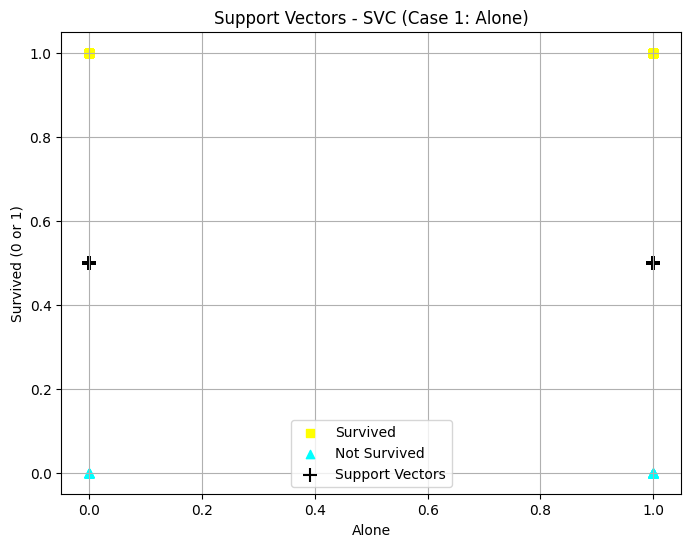

In [ ]:
# Visualize support vectors for Case 1 (feature = 'alone')
svc_model1 = SVC()                 # default RBF
svc_model1.fit(X1_train, y1_train)

# Create groups based on survival
survived_alone = X1_test.loc[y1_test == 1, 'alone']
not_survived_alone = X1_test.loc[y1_test == 0, 'alone']

# Create scatter plot for survived and not survived
plt.figure(figsize=(8, 6))

plt.scatter(survived_alone, y1_test.loc[y1_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_alone, y1_test.loc[y1_test == 0], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
# Check if the model has support_vectors_ (it may not if it failed to converge)
if hasattr(svc_model1, 'support_vectors_'):
    # Get the X-values of the support vectors (only one feature in Case 1
    support_x = svc_model1.support_vectors_[:, 0]  # First feature (alone)
    # Plot them using a fixed Y-value (0.5) to place them between classes visually
    # We use a larger size (s=100) and a plus symbol to make them stand out
    plt.scatter(support_x, [0.5] * len(support_x), c='black', marker='+', s=100, label='Support Vectors')

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 1: Alone)')
plt.legend()
plt.grid(True)
plt.show()

Case 3. Two Inputs, Two Dimensional Scatter Plot

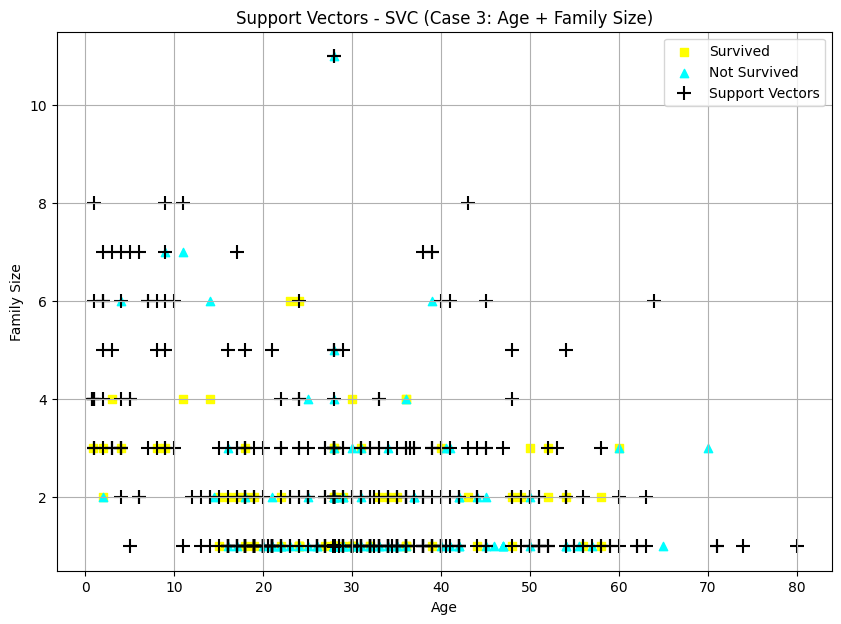

In [ ]:
# Visualize support vectors for Case 3 (features = 'age', 'family_size') - more interesting (two dimensional)
# Create groups based on survival
survived = X3_test[y3_test == 1]
not_survived = X3_test[y3_test == 0]

# Create scatter plot
plt.figure(figsize=(10, 7))

# Plot survived (yellow squares)
plt.scatter(survived['age'], survived['family_size'],
            c='yellow', marker='s', label='Survived')

# Plot not survived (cyan triangles)
plt.scatter(not_survived['age'], not_survived['family_size'],
            c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
if hasattr(svc_model3, 'support_vectors_'):
    support_vectors = svc_model3.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                c='black', marker='+', s=100, label='Support Vectors')

# Add labels, title, and legend
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Support Vectors - SVC (Case 3: Age + Family Size)')
plt.legend()
plt.grid(True)
plt.show()

5.3 Train and Evaluate Model (Neural Network on Case 3)

Train NN on Case 3

In [ ]:
# Train NN for Case 3 (age + family_size)
nn_model3 = MLPClassifier(
    hidden_layer_sizes=(50, 25, 10),
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

nn_model3.fit(X3_train, y3_train)

,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


Predict and evaluate Neural Network model:

In [ ]:
# Predict on test data (Case 3)
y3_nn_pred = nn_model3.predict(X3_test)

# Print classification report
print("Results for Neural Network on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_nn_pred))

Results for Neural Network on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       110
           1       0.57      0.46      0.51        69

    accuracy                           0.66       179
   macro avg       0.64      0.62      0.63       179
weighted avg       0.65      0.66      0.65       179



Plot confusion matrix:

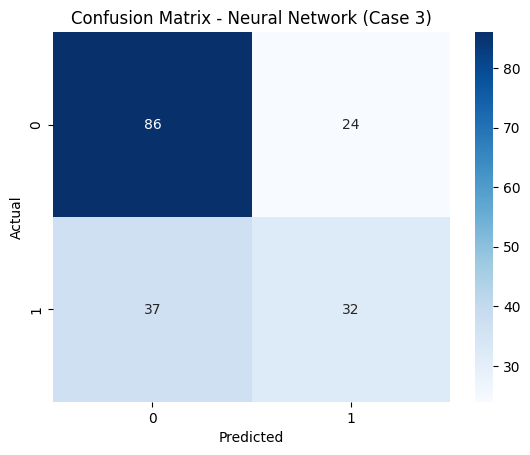

In [ ]:
# Create confusion matrix
cm_nn3 = confusion_matrix(y3_test, y3_nn_pred)

# Plot heatmap
sns.heatmap(cm_nn3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Neural Network (Case 3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

5.4 Visualize (Neural Network on Case 3)

c:\Projects\Repos\applied-ml-sowers\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


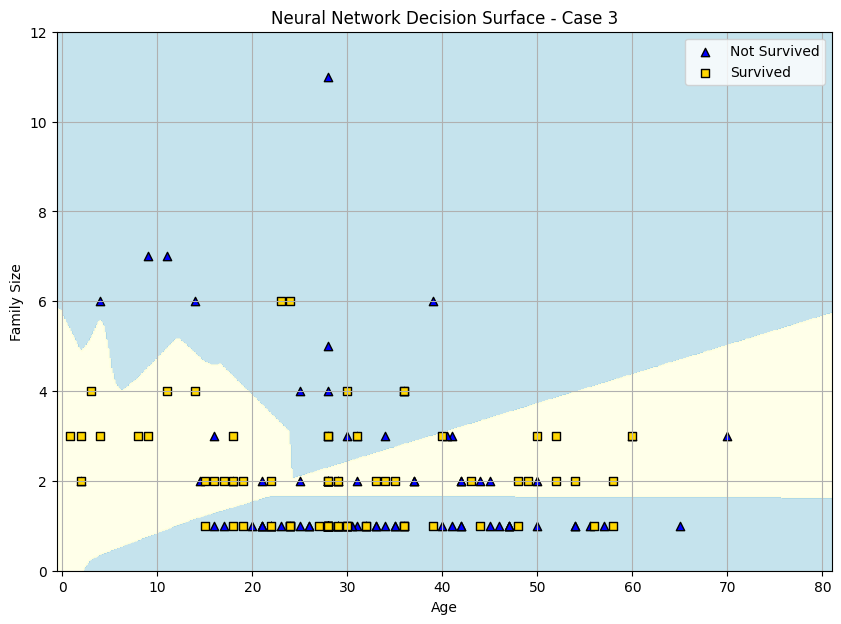

In [ ]:
# Get the range of our two features - use padding to enhance appearance

padding = 1
x_min, x_max = X3['age'].min() - padding, X3['age'].max() + padding
y_min, y_max = X3['family_size'].min() - padding, X3['family_size'].max() + padding

# Create a meshgrid (all combinations of age and family_size)

# A grid of values covering the entire input space
# np.linspace(start, stop, num) generates evenly spaced values (like a ruler)
# Here, we create 500 points between min and max for each axis
# np.meshgrid creates a coordinate grid from the two arrays

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                                    np.linspace(y_min, y_max, 500))

# Flatten the grid arrays and prepare them for prediction
# np.c_ stacks the flattened xx and yy into coordinate pairs
# .ravel() flattens a 2D array into 1D (required by the model for prediction)

Z = nn_model3.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted results to match the original 2D grid shape
Z = Z.reshape(xx.shape)

# Plot the decision surface (background) showing predicted survival zones

 # Blue for 0, yellow for 1 - change this up as you like
plt.figure(figsize=(10, 7))
cmap_background = ListedColormap(['lightblue', 'lightyellow'])

plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.7)

# Overlay the actual test data points for visual comparison

# Plot passengers who did NOT survive (0) as blue triangles
plt.scatter(X3_test['age'][y3_test == 0],
            X3_test['family_size'][y3_test == 0],
            c='blue', marker='^', edgecolor='k', label='Not Survived')

# Plot passengers who DID survive (1) as gold squares
plt.scatter(X3_test['age'][y3_test == 1],
            X3_test['family_size'][y3_test == 1],
            c='gold', marker='s', edgecolor='k', label='Survived')

# Add axis labels, title, legend, and grid
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Neural Network Decision Surface - Case 3')
plt.legend()
plt.grid(True)
plt.show()

Reflection 5:
1. How well did each of these new models/cases perform?
The SVC models showed similar accuracy to the decision trees when using one feature (Case 1 and Case 2), but they mostly predicted the “not survived” group correctly and struggled with predicting survivors. Case 3 (age + family_size) improved the ability to identify survivors a little, but recall for survivors was still low.
The Neural Network did slightly better overall in Case 3, especially at balancing predictions between survived and not survived. Its accuracy was around 0.66, which was higher than the SVC and Decision Tree results for that case.

2. Are there any surprising results or insights?
I expected age to be more meaningful by itself, but models using only age performed poorly at predicting survivors. It was also surprising that adding family_size caused the Decision Tree to overfit but helped the Neural Network separate the groups more smoothly. Another interesting point was how the SVC support vectors showed that many data points near the boundary are uncertain, which helps explain why the model struggled with survivors.

3. Why might one model outperform the others?
The Neural Network performed best in Case 3 because it can learn non-linear patterns between age and family_size, while SVC and Decision Trees struggled with those subtle relationships. The SVC models also rely heavily on correctly scaled input and clear margins, which were not always present in our data. The Decision Tree tended to memorize the training data instead of generalizing, especially in Case 3. The Neural Network was able to generalize better and form smoother boundaries across the input space.

## Section 6. Final Thoughts & Insights

| Model Type           | Case   | Features Used         | Accuracy | Precision | Recall | F1-Score | Notes |
|----------------------|--------|-----------------------|----------|-----------|--------|----------|-------|
| Decision Tree        | Case 1 | alone                 | 63%      | 64%       | 63%    | 63%      | Performs similarly to SVM; simple split on alone is limited. |
| Decision Tree        | Case 2 | age                   | 61%      | 58%       | 61%    | 55%      | Age alone did not predict survival well (especially survivors). |
| Decision Tree        | Case 3 | age + family_size     | 59%      | 57%       | 59%    | 58%      | Slight overfitting, training was higher than test accuracy. |
| SVM (RBF Kernel)     | Case 1 | alone                 | 63%      | 64%       | 63%    | 63%      | Single feature gives limited separation. |
| SVM (RBF Kernel)     | Case 2 | age                   | 63%      | 66%       | 63%    | 52%      | Improved precision but low recall for survivors. |
| SVM (RBF Kernel)     | Case 3 | age + family_size     | 63%      | 66%       | 63%    | 52%      | Extra feature didn’t noticeably improve performance. |
| Neural Network (MLP) | Case 3 | age + family_size     | 66%      | 65%       | 66%    | 65%      | Best performance overall, captured more complex patterns. |

**Insights**
- Using both age and family size together helped the models more than using only one feature. The Neural Network did the best because it could find more complex patterns.

**Challenges Faced**
- It was challening for the models to correctly predict survivors because fewer people survived in the dataset than not.
- Some models overfit, especially the Decision Tree when more features were added.
- Understanding how to choose and compare different models took time and a little trial-and-error.

**Next Steps**
- Adding more meaningful features (such as sex, class, or fare) because those are known to influence survival.
- Using a method to help balance survivor vs non-survivor counts so the model doesn’t automatically lean toward predicting “not survived”.